In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools  import durbin_watson
from scipy.stats import shapiro, normaltest, probplot

In [2]:
# Load dataset with new features
df = pd.read_excel('Project1Data.xlsx')

# Create the log of variables for better modeling (log-log model for elasticities)
df['log_qu'] = np.log(df['qu'])
df['log_cprice'] = np.log(df['cprice'])
df['log_tprice'] = np.log(df['tprice'])
df['log_oprice'] = np.log(df['oprice'])
df['log_income'] = np.log(df['incom'])
df['log_wprice'] = np.log(df['wprice'])
df['log_bprice'] = np.log(df['bprice'])
df['log_woodpulp'] = np.log(df['woodpulp'])
df['log_BrazilPrecipitation'] = np.log(df['BrazilPrecipitation'])
df['log_BrazilTASMean'] = np.log(df['BrazilTAS_Mean'])
df['log_BrazilTASMax'] = np.log(df['BrazilTAS_Max'])
df['log_EthioPrecipitation'] = np.log(df['EthioPrecipitation'])
df['log_ColombPrecipitation'] = np.log(df['ColombPrecipitation'])
df['log_VietPrecipitation'] = np.log(df['VietPrecipitation'])

In [3]:
def ds_ols(df, x_cols, y_col, const=True, print_summary=True, plot_name=''):
    '''
    demand / supply function
    df : input data (dataframe)
    x_cols : X variables
    y_col : Y variable
    '''
    # OLS 
    X = df[x_cols]
    y = df[y_col]

    # add a constant to the independent variable (intercept)
    if const:
        X = sm.add_constant(X)

    # fit the regression model
    model = sm.OLS(y, X).fit()

    # output the summary of the regression
    model_summary = model.summary()
    # print('model_summary:')
    # print(model_summary)
    if print_summary:
        print(plot_name,':')
        print(model_summary)
    
    return model

<h1>OLS with log transformed variables</h1>

In [4]:
# Demand function estimate
demand_ols = ds_ols(df, x_cols=['log_cprice','log_income','q1','q2','q3'], y_col=['log_qu'], plot_name='Demand function summary')

Demand function summary :
                            OLS Regression Results                            
Dep. Variable:                 log_qu   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     6.012
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           9.34e-05
Time:                        10:08:55   Log-Likelihood:                 79.150
No. Observations:                  84   AIC:                            -146.3
Df Residuals:                      78   BIC:                            -131.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3855     

In [5]:
# Supply function estimate
X_supply = ['log_cprice','log_wprice','q1','q2','q3']
y_supply = ['log_qu']
supply_ols = ds_ols(df, x_cols=['log_cprice','log_wprice','q1','q2','q3'], y_col=y_supply, plot_name='Supply function summary')

Supply function summary :
                            OLS Regression Results                            
Dep. Variable:                 log_qu   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     5.786
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           0.000136
Time:                        10:08:55   Log-Likelihood:                 78.708
No. Observations:                  84   AIC:                            -145.4
Df Residuals:                      78   BIC:                            -130.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3965     

<h1>TSLS with log transformed variables</h1>

In [6]:
# demand TSLS
demand_first_stage = ds_ols(df, x_cols=['log_bprice', 'log_wprice', 'log_income', 'q1', 'q2', 'q3'], y_col=['log_cprice'], plot_name='demand first stage')
df['log_cprice_pred_demand'] = demand_first_stage.fittedvalues
demand_second_stage = ds_ols(df, x_cols=['log_cprice_pred_demand','log_income','q1','q2','q3'], y_col=['log_qu'], plot_name='demand second stage')

demand first stage :
                            OLS Regression Results                            
Dep. Variable:             log_cprice   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     272.0
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           1.08e-49
Time:                        10:08:55   Log-Likelihood:                 159.99
No. Observations:                  84   AIC:                            -306.0
Df Residuals:                      77   BIC:                            -289.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8641      0.48

In [7]:
# supply TSLS
supply_first_stage = ds_ols(df, x_cols=['log_wprice', 'log_income', 'q1', 'q2', 'q3'], y_col=['log_cprice'], plot_name='supply first stage')
df['log_cprice_pred_supply'] = supply_first_stage.fittedvalues
supply_second_stage = ds_ols(df, x_cols=['log_cprice_pred_supply','log_wprice','q1','q2','q3'], y_col=['log_qu'], plot_name='supply second stage')

supply first stage :
                            OLS Regression Results                            
Dep. Variable:             log_cprice   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     16.59
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           3.94e-11
Time:                        10:08:55   Log-Likelihood:                 60.221
No. Observations:                  84   AIC:                            -108.4
Df Residuals:                      78   BIC:                            -93.86
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3163      1.36

<h1>Hausman Test</h1>

In [8]:
# Calculate the test statistic (Demand)

beta_demand_ols = demand_ols.params['log_cprice']
beta_demand_iv = demand_second_stage.params['log_cprice_pred_demand']

var_beta_demand_ols = demand_ols.cov_params().loc['log_cprice','log_cprice']
var_beta_demand_iv = demand_second_stage.cov_params().loc['log_cprice_pred_demand','log_cprice_pred_demand']

# Test statistic
H_demand = (beta_demand_ols - beta_demand_iv)**2 / (var_beta_demand_iv - var_beta_demand_ols)

# p-value
from scipy.stats.distributions import chi2
print(f'p-value : {chi2.sf(H_demand,1)}') # Degrees of freedom = numbers of parameters tested (usually the number of endogenous regressors)
print('')
#### betas and their var (Demand)
print(f'beta_demand_iv : {beta_demand_iv}')
print(f'beta_demand_ols : {beta_demand_ols}')
print(f'var_beta_demand_ols : {var_beta_demand_ols}')
print(f'var_beta_demand_iv : {var_beta_demand_iv}')
print(f'H_demand : {H_demand}')

p-value : 0.5094581625838597

beta_demand_iv : -0.2859157017812613
beta_demand_ols : -0.26726861074786173
var_beta_demand_ols : 0.008169051097307874
var_beta_demand_iv : 0.008968063298330503
H_demand : 0.435179842764432


In [9]:
# Calculate the test statistic (Supply)

beta_supply_ols = supply_ols.params['log_cprice']
beta_supply_iv = supply_second_stage.params['log_cprice_pred_supply'] # beta from 2SLS

var_beta_supply_ols = supply_ols.cov_params().loc['log_cprice','log_cprice']
var_beta_supply_iv = supply_second_stage.cov_params().loc['log_cprice_pred_supply','log_cprice_pred_supply']

# Test statistic
H_supply = (beta_supply_ols - beta_supply_iv)**2 / (var_beta_supply_iv - var_beta_supply_ols)

# p-value
print(f'p-value: {chi2.sf(H_supply,1)}') # Degrees of freedom = numbers of parameters tested (usually the number of endogenous regressors)'
print('')
#### betas and their var (Supply)
print(f'beta_supply_ols : {beta_supply_ols}')
print(f'beta_supply_iv : {beta_supply_iv}')
print(f'var_beta_supply_ols : {var_beta_supply_ols}')
print(f'var_beta_supply_iv : {var_beta_supply_iv}')
print(f'H_supply : {H_supply}')

p-value: 0.39021903655799417

beta_supply_ols : -0.24142811012717175
beta_supply_iv : -0.004969201499707587
var_beta_supply_ols : 0.007442718573969745
var_beta_supply_iv : 0.08317872421923632
H_supply : 0.7382593654486708


<h1>Multiple Linear Regression Assumptions</h1>
<ul>
<li>Linearity</li>
<li>Independence</li>
<li>Homoskedacity</li>
<li>Normality</li>
<li>Independent variables are not highly correlated</li>
</ul>

In [10]:
import warnings # ignore warning

# 1. Linearity: Residuals vs Fitted Plot
def plot_linearity(X, y):
    n_features = X.shape[1]-1
    n_features_to_plot = n_features - 3  # Exclude the last 3 dummy variable plots
    
    fig, axes = plt.subplots(n_features_to_plot, 1, figsize=(8, n_features_to_plot * 4))

    for i, col in enumerate(X.columns[1:n_features_to_plot+1]):  # Skip the constant term
        # Define the independent variable (X) and dependent variable (Y)
        X_lin = df[col] 
        y_lin = y
        # Add a constant to the independent variable (intercept)
        X_lin = sm.add_constant(X_lin)
        # Fit the regression model
        model_lin = sm.OLS(y_lin, X_lin).fit()

        fitted_values_lin = model_lin.fittedvalues

        sns.scatterplot(x=X[col], y=y, ax=axes[i])
        sns.lineplot(x=X[col], y=fitted_values_lin, ax=axes[i], color='red')
        # sns.lineplot(x=X[col], y=y, color='red', ax=axes[i], ci=None)
        axes[i].set_title(f'{col} vs log_qu (Linearity Check: : Scatter Plot with Regression Line)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('log_qu')

        # Set the y-axis scale (zoom out)
        ymin, ymax = axes[i].get_ylim()  # Get current y-axis limits
        axes[i].set_ylim(ymin * 2, ymax * 2)  # Scale the y-axis
        

    plt.tight_layout()
    plt.show()  
      
# 2. Independence: Durbin-Watson Test
def check_independence(model):
    residuals = model.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, marker='o', linestyle='none', color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residuals vs Observation Index (Independence Check)')
    plt.xlabel('Observation Index')
    plt.ylabel('Residuals')

    plt.show()

# 3. Homoscedasticity: Residuals Plot
def check_homoscedasticity(model, X):
    residuals = model.resid
    
    # Subplots of Residuals against each independent variable
    n_features = X.shape[1]-1 # Exclude the constant term
    n_features_to_plot = n_features - 3  # Exclude the last 3 dummy variable plots
    
    fig, axes = plt.subplots(n_features_to_plot, 1, figsize=(8, n_features_to_plot * 4))

    for i, col in enumerate(X.columns[1:n_features_to_plot+1]):  # Skip the constant term
        sns.residplot(x=X[col], y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2}, ax=axes[i])
        axes[i].set_title(f'Residuals vs {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

# 4. Normality
def check_normality(model):
    residuals = model.resid

    # Histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title('Histogram of Residuals (Normality Check)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


# Running all assumption checks
def check_assumptions(model, X, y):
    print("Checking Linearity...")
    plot_linearity(X, y)
    
    print("\nChecking Independence...")
    check_independence(model)
    
    print("\nChecking Homoskedasticity...")
    check_homoscedasticity(model, X)
    
    print("\nChecking Normality...")
    check_normality(model)


Checking Linearity...


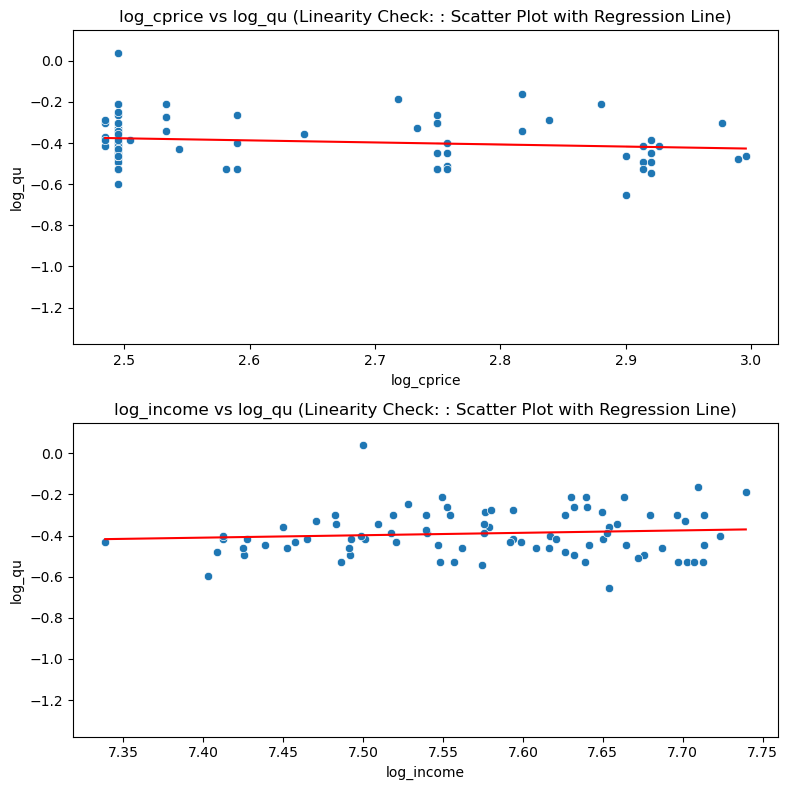


Checking Independence...


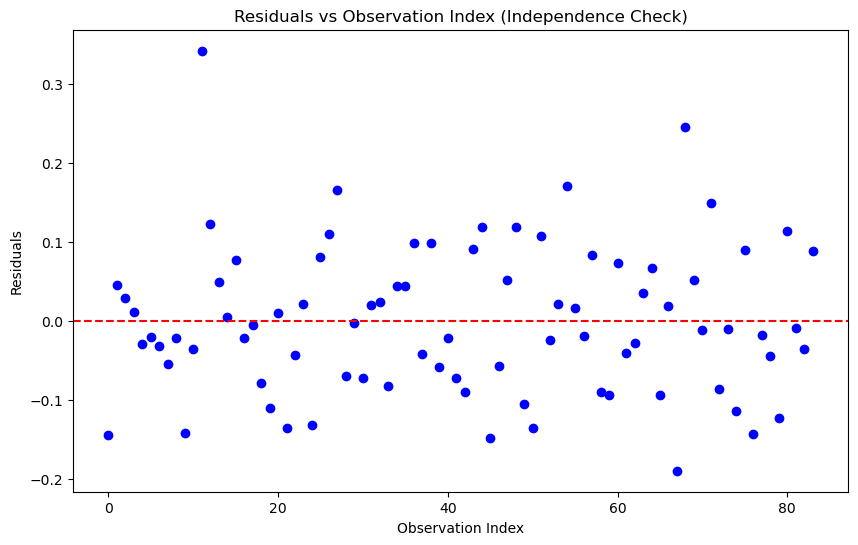


Checking Homoskedasticity...


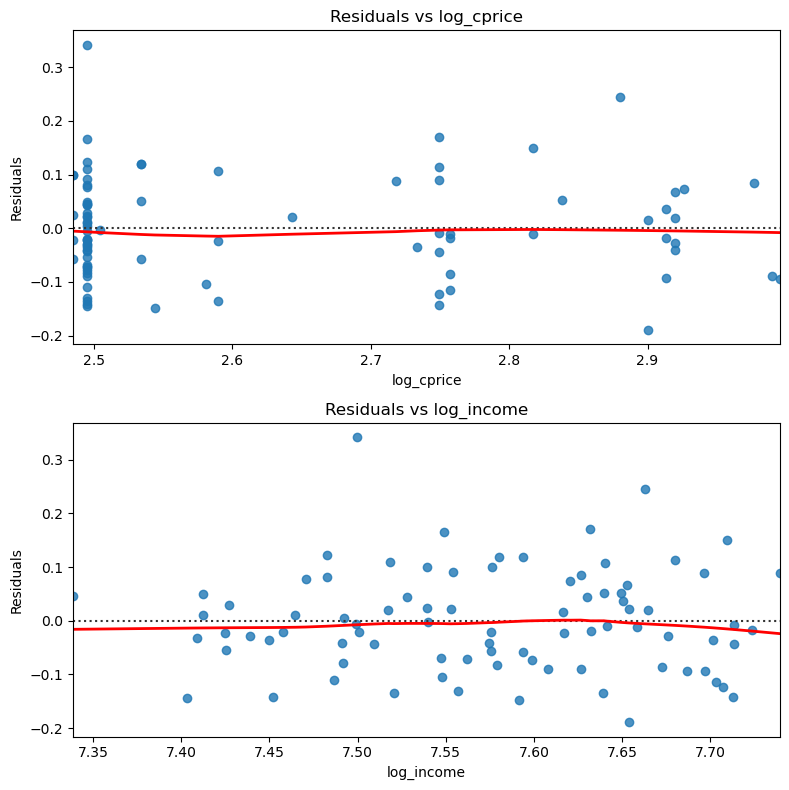


Checking Normality...


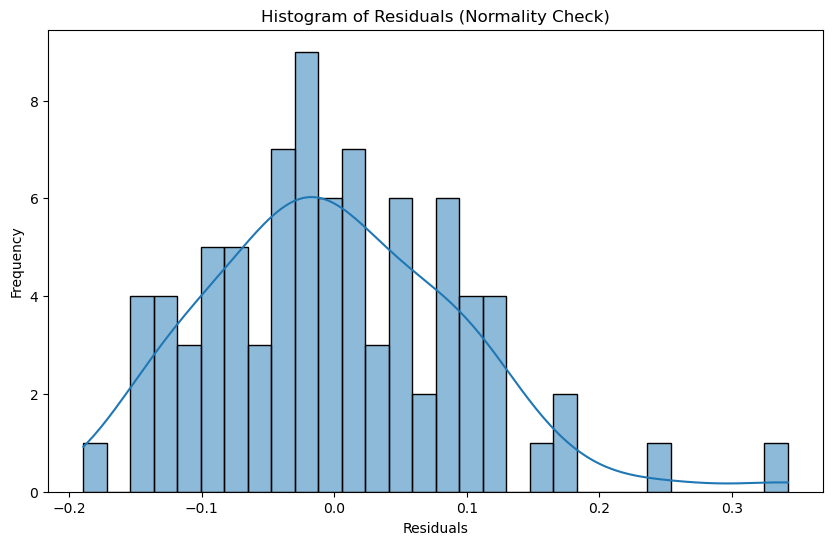

In [11]:
X_demand = df[['log_cprice','log_income','q1','q2','q3']]
X_demand = sm.add_constant(X_demand)
y_demand = df['log_qu']

check_assumptions(demand_ols, X_demand, y_demand)

Typically, a correlation coefficient above 0.8 or 0.9 between two independent variables suggests multicollinearity may exist.

Source: https://sougaaat.medium.com/multicollinearity-explained-dealing-with-correlated-variables-in-regression-analysis-a76e215fb13c#:~:text=If%20there%20are%20off%2Ddiagonal,and%20may%20be%20causing%20multicollinearity

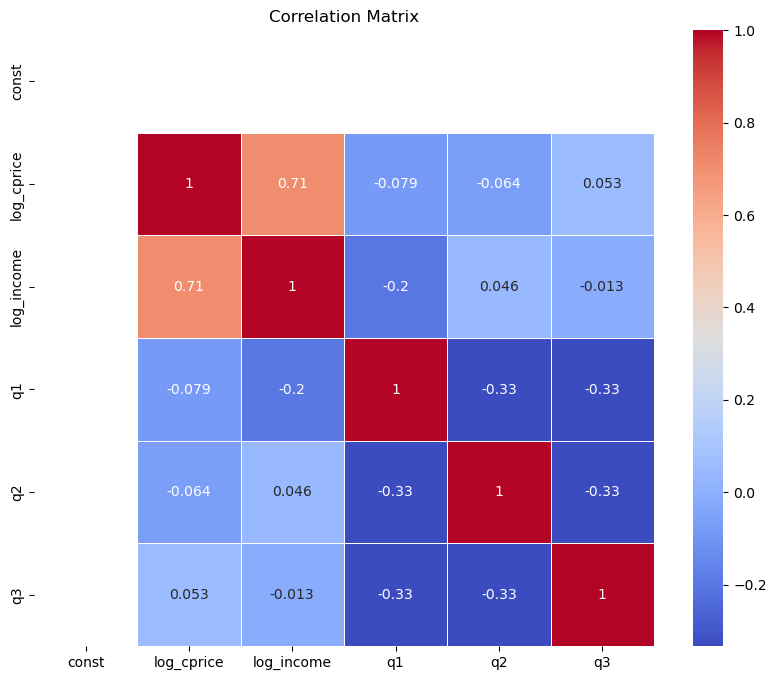

In [12]:
# 5. Assumption: Independent variables are not highly correlated

# Create a correlation matrix
corr_matrix = X_demand.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Variance Inflation Factor (VIF)

A variance inflation factor (VIF) is a measure of the amount of multicollinearity in regression analysis. Multicollinearity exists when there is a correlation between multiple independent variables in a multiple regression model.

In general terms,

<li>VIF equal to 1 = variables are not correlated</li>
<li>VIF between 1 and 5 = variables are moderately correlated</li>
<li>VIF greater than 5 = variables are highly correlated</li>

Source: https://www.investopedia.com/terms/v/variance-inflation-factor.asp

In [13]:
# 5. Assumption: Independent variables are not highly correlated

# Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X_demand.columns
vif["VIF"] = [variance_inflation_factor(X_demand.values, i) for i in range(X_demand.shape[1])]

print(vif)

     Variable           VIF
0       const  10696.814720
1  log_cprice      2.063691
2  log_income      2.142836
3          q1      1.590240
4          q2      1.513671
5          q3      1.529607


Checking Linearity...


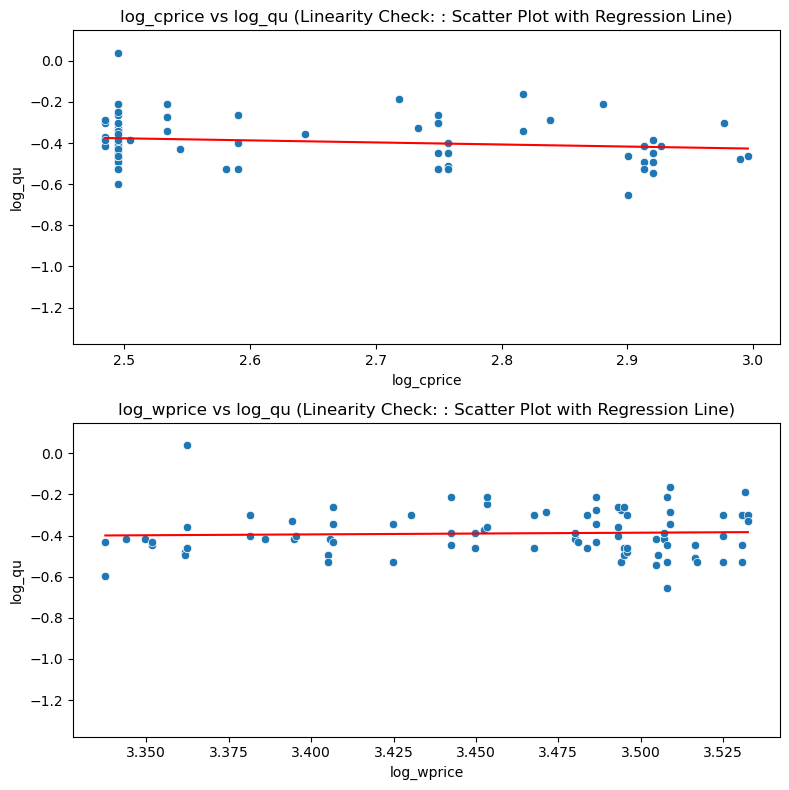


Checking Independence...


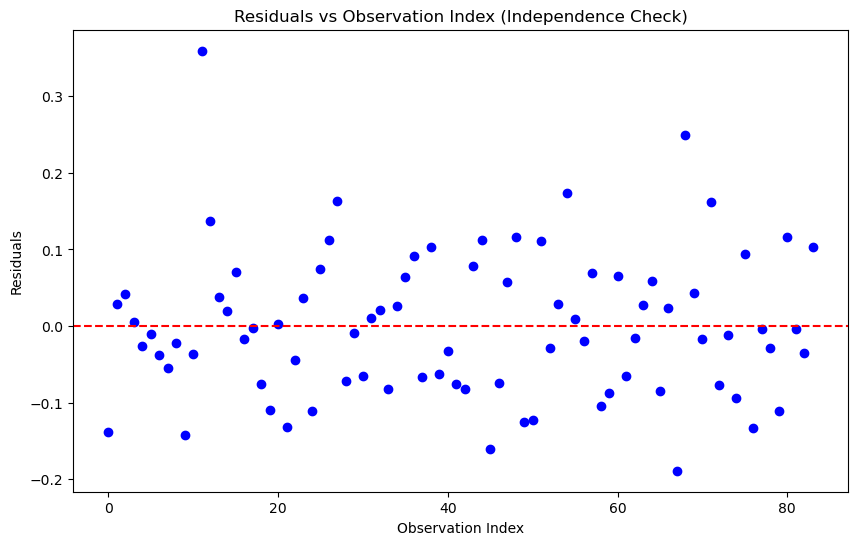


Checking Homoskedasticity...


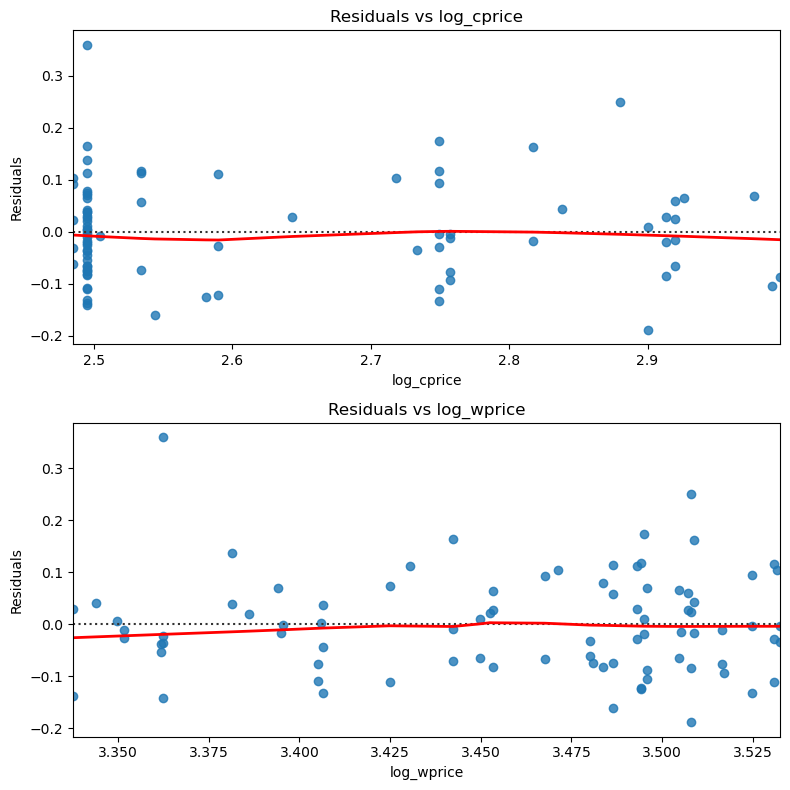


Checking Normality...


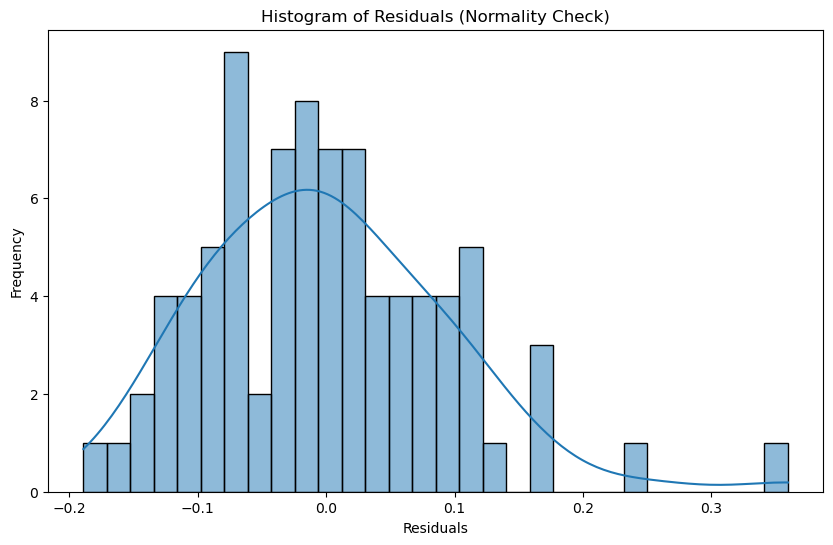

In [14]:
X_supply = df[['log_cprice','log_wprice','q1','q2','q3']]
X_supply = sm.add_constant(X_supply)
y_supply = df['log_qu']

check_assumptions(supply_ols, X_supply, y_supply)

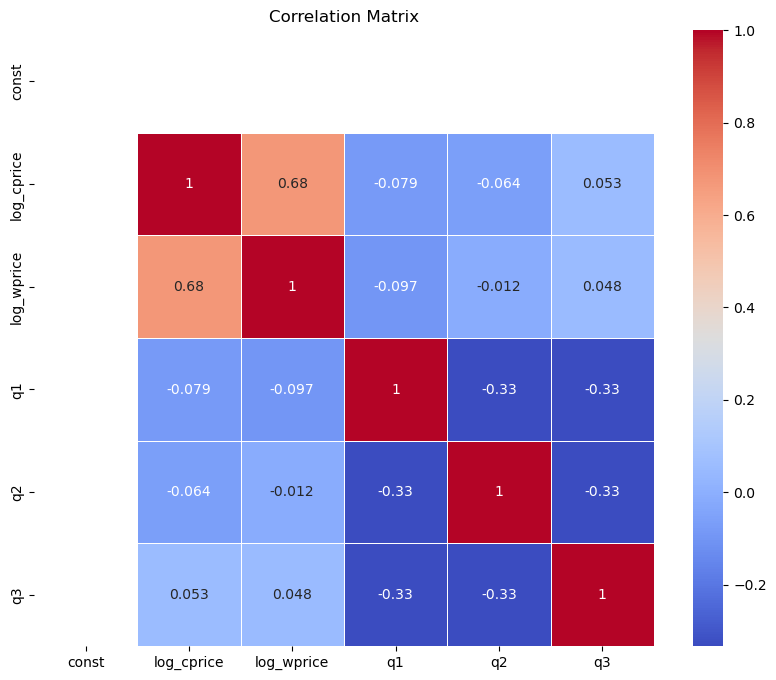

In [15]:
# 5. Assumption: Independent variables are not highly correlated

# Create a correlation matrix
corr_matrix = X_supply.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [16]:
# 5. Assumption: Independent variables are not highly correlated

# Variance Inflation Factor (VIF)

# Compute VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X_supply.columns
vif["VIF"] = [variance_inflation_factor(X_supply.values, i) for i in range(X_supply.shape[1])]

print(vif)

     Variable          VIF
0       const  4622.857679
1  log_cprice     1.860511
2  log_wprice     1.852460
3          q1     1.518220
4          q2     1.514414
5          q3     1.500872


<h1>Trying other Models</h1>

In [17]:
# Function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [18]:
# --- Dd (Demand) Model Features ---
X_demand = df[['cprice', 'tprice', 'oprice', 'incom', 'q1', 'q2', 'q3', 'q4']]  # Demand side features
y_demand = df['qu']  # Target variable (quantity)

# --- Ss (Supply) Model Features ---
X_supply = df[['cprice', 'bprice', 'wprice', 'q1', 'q2', 'q3', 'q4']]  # Supply side features
y_supply = df['qu']  # Target variable (quantity)

# Train-Test Split
X_demand_train, X_demand_test, y_demand_train, y_demand_test = train_test_split(X_demand, y_demand, test_size=0.2, random_state=42)
X_supply_train, X_supply_test, y_supply_train, y_supply_test = train_test_split(X_supply, y_supply, test_size=0.2, random_state=42)

# Standardize the data (for Ridge, Lasso, SVR)
scaler_demand = StandardScaler()
X_demand_train_scaled = scaler_demand.fit_transform(X_demand_train)
X_demand_test_scaled = scaler_demand.transform(X_demand_test)

scaler_supply = StandardScaler()
X_supply_train_scaled = scaler_supply.fit_transform(X_supply_train)
X_supply_test_scaled = scaler_supply.transform(X_supply_test)

# Define models for comparison (can add more models)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

# Try models for Dd (Demand) and Ss (Supply)
results_demand = {}
results_supply = {}

for name, model in models.items():
    print(f"Training {name} for Demand model (Dd)...")
    mse_d, r2_d = evaluate_model(model, X_demand_train_scaled, y_demand_train, X_demand_test_scaled, y_demand_test)
    results_demand[name] = {"MSE": mse_d, "R^2": r2_d}

    print(f"Training {name} for Supply model (Ss)...")
    mse_s, r2_s = evaluate_model(model, X_supply_train_scaled, y_supply_train, X_supply_test_scaled, y_supply_test)
    results_supply[name] = {"MSE": mse_s, "R^2": r2_s}

# Convert results to DataFrames for easy comparison
results_demand_df = pd.DataFrame(results_demand).T
results_supply_df = pd.DataFrame(results_supply).T

# Display the results for Demand (Dd) and Supply (Ss)
print("\nDemand (Dd) Model Performance:")
print(results_demand_df.sort_values(by='R^2', ascending=False))

print("\nSupply (Ss) Model Performance:")
print(results_supply_df.sort_values(by='R^2', ascending=False))


Training Linear Regression for Demand model (Dd)...
Training Linear Regression for Supply model (Ss)...
Training Ridge Regression for Demand model (Dd)...
Training Ridge Regression for Supply model (Ss)...
Training Lasso Regression for Demand model (Dd)...
Training Lasso Regression for Supply model (Ss)...
Training Decision Tree for Demand model (Dd)...
Training Decision Tree for Supply model (Ss)...
Training Random Forest for Demand model (Dd)...
Training Random Forest for Supply model (Ss)...

Demand (Dd) Model Performance:
                        MSE       R^2
Linear Regression  0.003128  0.411950
Ridge Regression   0.003236  0.391686
Random Forest      0.003648  0.314211
Lasso Regression   0.005341 -0.004148
Decision Tree      0.007029 -0.321559

Supply (Ss) Model Performance:
                        MSE       R^2
Ridge Regression   0.003643  0.315029
Linear Regression  0.003681  0.307981
Lasso Regression   0.005341 -0.004148
Random Forest      0.006751 -0.269248
Decision Tree     

<h1>Find best variable combination</h1>

In [19]:
def find_best_supply_model(df):
    """
    Find the best supply function model with lowest p-values and positive log_cprice coefficient.
    """
    # Define the set of variables to try in different combinations (excluding log_wprice, q1, q2, q3)
    possible_vars = [ 'log_EthioPrecipitation', 'log_VietPrecipitation' , 'log_ColombPrecipitation',   'log_BrazilPrecipitation']  # Add or remove variables here as needed 'log_bprice',
                     
    best_model = None
    best_pvalue_sum = float('inf')  # Start with an infinitely large p-value sum
    best_X_supply = None
    best_y_supply = None

    # Iterate over all possible combinations of variables (excluding log_cprice, log_wprice, q1, q2, q3)
    for r in range(1, len(possible_vars) + 1):
        for subset in itertools.combinations(possible_vars, r):
            # Include log_cprice, log_wprice, q1, q2, and q3 in all models
            selected_vars = ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3'] + list(subset)

            # Print each iteration on the same line
            print(f"Trying variables: {selected_vars}", end=" | ")

            X_supply = df[selected_vars]  # Always include log_cprice, log_wprice, q1, q2, q3
            X_supply = sm.add_constant(X_supply)  # Add intercept
            y_supply = df['log_qu']

            # OLS regression for supply
            supply_model = sm.OLS(y_supply, X_supply).fit()

            # Check if the p-values of all variables are below a threshold, or in this case find the combination with lowest p-value
            pvalues = supply_model.pvalues
            pvalue_sum = pvalues.sum() 

            # Ensure the coefficient of log_cprice is positive
            if pvalue_sum < best_pvalue_sum: #supply_model.params['log_cprice'] > 0 and
                best_model = supply_model
                best_pvalue_sum = pvalue_sum
                best_X_supply = X_supply
                best_y_supply = y_supply

    # Return the best model and the associated data
    return best_model, best_X_supply, best_y_supply

# Assuming df is your dataframe and it is already prepared with the log variables
best_model, best_X_supply, best_y_supply = find_best_supply_model(df)

# Print the summary of the best model
if best_model is not None:
    print("\nBest model found:")
    print(best_model.summary())
else:
    print("\nNo suitable model found.")


Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_EthioPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_VietPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_ColombPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_BrazilPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_EthioPrecipitation', 'log_VietPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_EthioPrecipitation', 'log_ColombPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_EthioPrecipitation', 'log_BrazilPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_VietPrecipitation', 'log_ColombPrecipitation'] | Trying variables: ['log_cprice', 'log_wprice', 'q1', 'q2', 'q3', 'log_VietPrecipitation', 'log_BrazilPrecipitation'] | Trying variables: ['log_cprice'

In [20]:
def find_best_demand_model(df):
    """
    Find the best demand function model with lowest p-values and positive log_cprice coefficient.
    """
    # Define the set of variables to try in different combinations (excluding log_wprice, q1, q2, q3)
    possible_vars = ['log_tprice', 'log_oprice', 'q4']  # Add or remove variables here as needed 'log_bprice',
                     
    best_model = None
    best_pvalue_sum = float('inf')  # Start with an infinitely large p-value sum
    best_X_demand = None
    best_y_demand = None

    # Iterate over all possible combinations of variables (excluding log_cprice, log_wprice, q1, q2, q3)
    for r in range(1, len(possible_vars) + 1):
        for subset in itertools.combinations(possible_vars, r):
            # Include log_cprice, log_wprice, q1, q2, and q3 in all models
            selected_vars = ['log_cprice' , 'log_income', 'q1', 'q2', 'q3'] + list(subset)

            # Print each iteration on the same line
            print(f"Trying variables: {selected_vars}", end=" | ")

            X_demand = df[selected_vars]  # Always include log_cprice, log_wprice, q1, q2, q3
            X_demand = sm.add_constant(X_demand)  # Add intercept
            y_demand = df['log_qu']

            # OLS regression for demand
            demand_model = sm.OLS(y_demand, X_demand).fit()

            # Check if the p-values of all variables are below a threshold, or in this case find the combination with lowest p-value
            pvalues = demand_model.pvalues
            pvalue_sum = pvalues.sum() 

            # Ensure the coefficient of log_cprice is positive
            if pvalue_sum < best_pvalue_sum: #demand_model.params['log_cprice'] > 0 and
                best_model = demand_model
                best_pvalue_sum = pvalue_sum
                best_X_demand = X_demand
                best_y_demand = y_demand

    # Return the best model and the associated data
    return best_model, best_X_demand, best_y_demand

# Assuming df is your dataframe and it is already prepared with the log variables
best_model, best_X_demand, best_y_demand = find_best_demand_model(df)

# Print the summary of the best model
if best_model is not None:
    print("\nBest model found:")
    print(best_model.summary())
else:
    print("\nNo suitable model found.")


Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'log_tprice'] | Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'log_oprice'] | Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'q4'] | Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'log_tprice', 'log_oprice'] | Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'log_tprice', 'q4'] | Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'log_oprice', 'q4'] | Trying variables: ['log_cprice', 'log_income', 'q1', 'q2', 'q3', 'log_tprice', 'log_oprice', 'q4'] | 
Best model found:
                            OLS Regression Results                            
Dep. Variable:                 log_qu   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     6.012
Date:                Fri, 20 Sep 2024   Prob (F-statistic): 

# lasso 

In [24]:
# demand
lasso_model = Lasso(alpha=0)
lasso_model.fit(df[['log_cprice', 'log_income', 'q1', 'q2', 'q3']], df['log_qu'])
y_pred = lasso_model.predict(df[['log_cprice', 'log_income', 'q1', 'q2', 'q3']])
mse = mean_squared_error(y_pred, df['log_qu'])
print('mean_squared_error:',mse)
print('Lasso coefficients:',lasso_model.coef_)

mean_squared_error: 0.008893817840199027
Lasso coefficients: [-0.26726861  0.36656135 -0.11464015 -0.09171949 -0.10960425]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e-01, tolerance: 1.035e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi

In [25]:
# supply
lasso_model = Lasso(alpha=0)
lasso_model.fit(df[['log_cprice', 'log_wprice', 'q1', 'q2', 'q3']], df['log_qu'])
y_pred = lasso_model.predict(df[['log_cprice', 'log_wprice', 'q1', 'q2', 'q3']])
mse = mean_squared_error(y_pred, df['log_qu'])
print('mean_squared_error:',mse)
print('Lasso coefficients:',lasso_model.coef_)

mean_squared_error: 0.008987952387588476
Lasso coefficients: [-0.24142811  0.49921128 -0.12723001 -0.09405866 -0.11941014]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.775e-01, tolerance: 1.035e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi

In [26]:
# supply
lasso_model = Lasso(alpha=0)
lasso_model.fit(df[['log_cprice', 'log_wprice', 'q1', 'q2', 'q3',
                    'log_tprice','log_oprice', 'log_bprice',
                    'log_woodpulp', 'log_BrazilPrecipitation',
                    'log_BrazilTASMean', 'log_BrazilTASMax', 'log_EthioPrecipitation','log_ColombPrecipitation', 'log_VietPrecipitation'
                    ]], df['log_qu'])
y_pred = lasso_model.predict(df[['log_cprice', 'log_wprice', 'q1', 'q2', 'q3',
                    'log_tprice','log_oprice', 'log_bprice',
                    'log_woodpulp', 'log_BrazilPrecipitation',
                    'log_BrazilTASMean', 'log_BrazilTASMax', 'log_EthioPrecipitation',
                    'log_ColombPrecipitation', 'log_VietPrecipitation'
                    ]])
mse = mean_squared_error(y_pred, df['log_qu'])
print('mean_squared_error:',mse)
print('Lasso coefficients:',lasso_model.coef_)

mean_squared_error: 0.0067915184644543325
Lasso coefficients: [ 0.02856776 -0.01105899 -0.24417348 -0.06071536  0.01259984  0.47519088
  0.18111332 -0.16841519  0.0242639   0.01934913  1.1597384  -1.3844038
 -0.02333462  0.00993513 -0.06688705]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e-01, tolerance: 1.035e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi